In [12]:
import pandas as pd

base_a = pd.read_csv('C:/Users/milen/OneDrive/Documentos/TCC/Bases/preco_cafe_v2.csv')
# Ler a base "b"
base_b = pd.read_csv('C:/Users/milen/OneDrive/Documentos/TCC/Bases/clima_patrocinio_preprocessada.csv')
# Ler a base "c" sem a especificação do delimitador
base_c = pd.read_csv('C:/Users/milen/OneDrive/Documentos/TCC/Bases/ibovespa_preprocessada.csv')

In [9]:
base_a

,Preco_Real,Preco_Dolar
Data,,
2006-08-23,NaN,"111,45"
2006-08-24,NaN,"111,21"
2006-08-25,NaN,"110,43"
2006-08-28,NaN,"107,83"
2006-08-29,NaN,"108,37"
...,...,...
2023-05-17,NaN,"211,05"
2023-05-18,NaN,"209,98"
2023-05-19,NaN,"211,48"


Loaded Data Shape: (4173, 2)
First 5 Rows of Loaded Data:
             Preco_Real  Preco_Dolar
Data                               
2006-08-23      239.83       111.45
2006-08-24      239.55       111.21
2006-08-25      238.20       110.43
2006-08-28      230.76       107.83
2006-08-29      231.69       108.37
Start of Test Data: 2016-09-08 00:00:00
End of Test Data: 2020-01-14 00:00:00


c:\Users\milen\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\milen\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\milen\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\milen\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the 

Best SARIMA Order: (1, 0, 2)
Best SARIMA Seasonal Order: (2, 0, 1, 12)
Best MSE: 1127.1194836667596
MSE with Test Data: 1127.1194836667596
MSE with Validation Data: 362418.6502049375


c:\Users\milen\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\milen\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\milen\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\milen\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the n

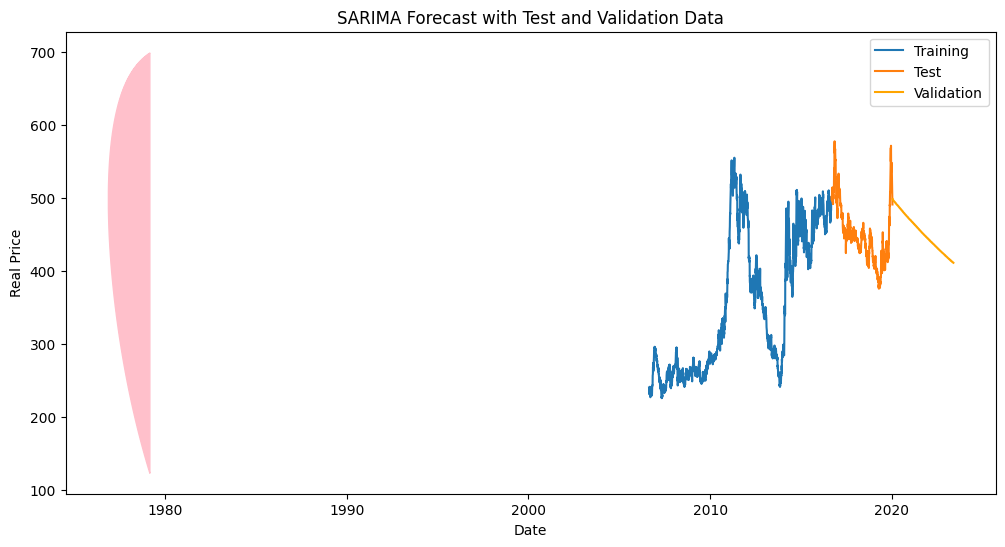

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Load your data and prepare it as shown earlier
# Load your data (replace 'base_a' with your data)
data = base_a.copy()  # Copy the DataFrame to avoid modifying the original data
data['Data'] = pd.to_datetime(data['Data'])
data.set_index('Data', inplace=True)
data['Preco_Real'] = data['Preco_Real'].str.replace(',', '.', regex=True).astype(float)
data['Preco_Dolar'] = data['Preco_Dolar'].str.replace(',', '.', regex=True).astype(float)

# After loading the data
print("Loaded Data Shape:", data.shape)
print("First 5 Rows of Loaded Data:\n", data.head())

# Split the data into training, test, and validation sets
train_size = int(0.6 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:train_size + test_size]
val_data = data.iloc[train_size + test_size:]

# Ensure train and test data have the same frequency
assert train_data.index.freq == test_data.index.freq, "Train and test data have different frequencies."

# Debug the time index
print("Start of Test Data:", test_data.index[0])
print("End of Test Data:", test_data.index[-1])


# Define the range of p, d, and q values for both non-seasonal and seasonal components
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
s = 12  # Assuming monthly data with a 12-month seasonality

# Create a list of all possible combinations of orders
orders = list(itertools.product(p_values, d_values, q_values))
seasonal_orders = list(itertools.product(P_values, D_values, Q_values, [s]))

best_mse = float('inf')
best_order = None
best_seasonal_order = None

# Iterate through all possible order combinations
for order in orders:
    for seasonal_order in seasonal_orders:
        try:
            model = SARIMAX(train_data['Preco_Real'], order=order, seasonal_order=seasonal_order)
            results = model.fit()

            # Make predictions with the test data
            forecast = results.get_forecast(steps=len(test_data))
            predicted = forecast.predicted_mean

            # Calculate MSE
            mse = mean_squared_error(test_data['Preco_Real'], predicted)

            if mse < best_mse:
                best_mse = mse
                best_order = order
                best_seasonal_order = seasonal_order

        except Exception as e:
            continue

# Print the best SARIMA orders and MSE
print("Best SARIMA Order:", best_order)
print("Best SARIMA Seasonal Order:", best_seasonal_order)
print("Best MSE:", best_mse)

# Now, fit the SARIMA model with the best orders
model = SARIMAX(train_data['Preco_Real'], order=best_order, seasonal_order=best_seasonal_order)
results = model.fit()

# Make predictions with the test data
forecast = results.get_forecast(steps=len(test_data))
predicted = forecast.predicted_mean

# Calculate the MSE with test data
mse = mean_squared_error(test_data['Preco_Real'], predicted)
print("MSE with Test Data:", mse)

# Make predictions with the validation data
forecast_val = results.get_forecast(steps=len(val_data))
predicted_val = forecast_val.predicted_mean

# Calculate the MSE with validation data
mse_val = mean_squared_error(val_data['Preco_Real'], predicted_val)
print("MSE with Validation Data:", mse_val)

# Plot the predictions with test and validation data
forecast_ci = forecast.conf_int()
plt.figure(figsize=(12, 6))
plt.plot(train_data['Preco_Real'], label='Training')
plt.plot(test_data['Preco_Real'], label='Test')
plt.plot(val_data.index, predicted_val, label='Validation', color='orange')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title('SARIMA Forecast with Test and Validation Data')
plt.xlabel('Date')
plt.ylabel('Real Price')
plt.legend()
plt.show()


Loaded Data Shape: (4173, 2)
First 5 Rows of Loaded Data:
             Preco_Real  Preco_Dolar
Data                               
2006-08-23      239.83       111.45
2006-08-24      239.55       111.21
2006-08-25      238.20       110.43
2006-08-28      230.76       107.83
2006-08-29      231.69       108.37
Start of Test Data: 2016-09-08 00:00:00
End of Test Data: 2020-01-14 00:00:00


c:\Users\milen\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\milen\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\milen\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\milen\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the 

Best SARIMA Order: (1, 0, 2)
Best SARIMA Seasonal Order: (2, 0, 1, 12)
Best MSE: 1127.1194836667596


c:\Users\milen\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\milen\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\milen\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\milen\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the n

MSE with Test Data: 1127.1194836667596
MSE with Validation Data: 362418.6502049375


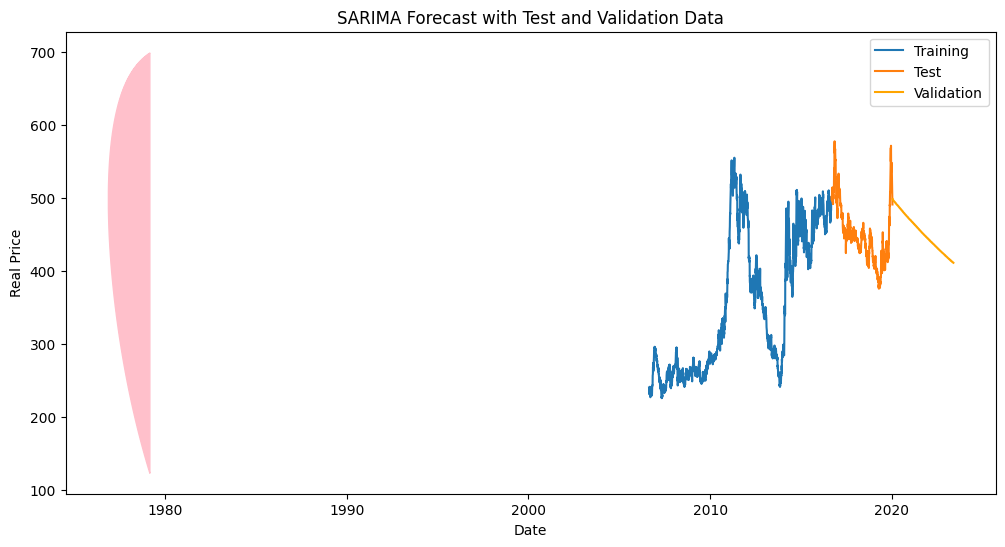

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools

# Load your data (replace 'base_a' with your data)
data = base_a.copy()  # Copy the DataFrame to avoid modifying the original data
data['Data'] = pd.to_datetime(data['Data'])
data.set_index('Data', inplace=True)
data['Preco_Real'] = data['Preco_Real'].str.replace(',', '.', regex=True).astype(float)
data['Preco_Dolar'] = data['Preco_Dolar'].str.replace(',', '.', regex=True).astype(float)

# After loading the data
print("Loaded Data Shape:", data.shape)
print("First 5 Rows of Loaded Data:\n", data.head())

# Split the data into training, test, and validation sets
train_size = int(0.6 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:train_size + test_size]
val_data = data.iloc[train_size + test_size:]

# Ensure train and test data have the same frequency
assert train_data.index.freq == test_data.index.freq, "Train and test data have different frequencies."

# Debug the time index
print("Start of Test Data:", test_data.index[0])
print("End of Test Data:", test_data.index[-1])


# Rest of your code for SARIMA modeling and forecasting

# Define the range of p, d, and q values for both non-seasonal and seasonal components
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
s = 12  # Assuming monthly data with a 12-month seasonality

# Create a list of all possible combinations of orders
orders = list(itertools.product(p_values, d_values, q_values))
seasonal_orders = list(itertools.product(P_values, D_values, Q_values, [s]))

best_mse = float('inf')
best_order = None
best_seasonal_order = None

# Iterate through all possible order combinations
for order in orders:
    for seasonal_order in seasonal_orders:
        try:
            model = SARIMAX(train_data['Preco_Real'], order=order, seasonal_order=seasonal_order)
            results = model.fit()

            # Make predictions with the test data
            forecast = results.get_forecast(steps=len(test_data))
            predicted = forecast.predicted_mean

            # Calculate MSE
            mse = mean_squared_error(test_data['Preco_Real'], predicted)

            if mse < best_mse:
                best_mse = mse
                best_order = order
                best_seasonal_order = seasonal_order

        except Exception as e:
            continue
.
# Print the best SARIMA orders and MSE
print("Best SARIMA Order:", best_order)
print("Best SARIMA Seasonal Order:", best_seasonal_order)
print("Best MSE:", best_mse)

# Now, fit the SARIMA model with the best orders
model = SARIMAX(train_data['Preco_Real'], order=best_order, seasonal_order=best_seasonal_order)
results = model.fit()

# Make predictions with the test data
forecast = results.get_forecast(steps=len(test_data))
predicted = forecast.predicted_mean

# Calculate the MSE with test data
mse = mean_squared_error(test_data['Preco_Real'], predicted)
print("MSE with Test Data:", mse)

# Make predictions with the validation data
forecast_val = results.get_forecast(steps=len(val_data))
predicted_val = forecast_val.predicted_mean

# Calculate the MSE with validation data
mse_val = mean_squared_error(val_data['Preco_Real'], predicted_val)
print("MSE with Validation Data:", mse_val)

# Plot the predictions with test and validation data
forecast_ci = forecast.conf_int()
plt.figure(figsize=(12, 6))
plt.plot(train_data['Preco_Real'], label='Training')
plt.plot(test_data['Preco_Real'], label='Test')
plt.plot(val_data.index, predicted_val, label='Validation', color='orange')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title('SARIMA Forecast with Test and Validation Data')
plt.xlabel('Date')
plt.ylabel('Real Price')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Carregar os dados
data = base_a
data['Data'] = pd.to_datetime(data['Data'])
data.set_index('Data', inplace=True)
data['Preco_Real'] = pd.to_numeric(data['Preco_Real'], errors='coerce')
data = data.dropna(subset=['Preco_Real'])

# Explorar os dados
plt.figure(figsize=(12, 6))
plt.plot(data['Preco_Real'])
plt.title('Preço Real ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Preço Real')
plt.show()

# Dividir os dados em treinamento, teste e validação
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:train_size+test_size]
val_data = data.iloc[train_size+test_size:]

# Identificar ordens do modelo SARIMA
order = (1, 1, 1)  # Substitua pelas ordens adequadas (p, d, q)
seasonal_order = (1, 1, 1, 12)  # Substitua pelas ordens adequadas (P, D, Q, S)

# Ajustar o modelo SARIMA com os dados de treinamento
model = SARIMAX(train_data['Preco_Real'], order=order, seasonal_order=seasonal_order)
results = model.fit()

# Fazer previsões com os dados de teste
forecast = results.get_forecast(steps=len(test_data))

# Intervalo de confiança
forecast_ci = forecast.conf_int()

# Plotar previsões com os dados de teste
plt.figure(figsize=(12, 6))
plt.plot(train_data['Preco_Real'], label='Treinamento')
plt.plot(test_data['Preco_Real'], label='Teste')
plt.plot(forecast.predicted_mean, label='Previsão', color='r')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title('Previsão SARIMA com Dados de Teste')
plt.xlabel('Data')
plt.ylabel('Preço Real')
plt.legend()
plt.show()

# Dados reais e previsões com dados de teste
observed = test_data['Preco_Real']
predicted = forecast.predicted_mean

# Calcular o erro quadrático médio (MSE) com dados de teste
mse = mean_squared_error(observed, predicted)
print("Erro Quadrático Médio (MSE) com Dados de Teste:", mse)

# Fazer previsões com os dados de validação
forecast_val = results.get_forecast(steps=len(val_data))

# Calcular o erro quadrático médio (MSE) com dados de validação
observed_val = val_data['Preco_Real']
predicted_val = forecast_val.predicted_mean
mse_val = mean_squared_error(observed_val, predicted_val)
print("Erro Quadrático Médio (MSE) com Dados de Validação:", mse_val)


In [ ]:
pip install Flask


In [ ]:
from flask import Flask, request, jsonify

app = Flask(__name__)

# Exemplo de dados das paradas
paradas = [
    {
        "cp": 340015329,
        "np": "AFONSO BRAZ B/C1",
        "ed": "R ARMINDA/ R BALTHAZAR DA VEIGA",
        "py": -23.592938,
        "px": -46.672727
    },
    # Adicione mais paradas conforme necessário
]

# Função para verificar o token de autorização
def verificar_token(token):
    # Implemente a lógica para verificar se o token é válido aqui
    return token == "2800bba5141feb67b2d3bafc8145c1c962ca1c208bac36075b4f889e8513e8bf"  # Substitua com o seu token real

@app.route('/Parada/BuscarParadasPorLinha', methods=['GET'])
def buscar_paradas_por_linha():
    codigo_linha = request.args.get('codigoLinha')
    
    # Obtenha o token de autorização do cabeçalho da solicitação
    token = request.headers.get('Authorization')

    # Verifique se o token é válido
    if not token or not verificar_token(token):
        return jsonify({"error": "Token de autorização inválido"}), 401

    # Aqui você pode implementar a lógica para buscar paradas com base no código da linha
    # Neste exemplo, estamos retornando todas as paradas, mas você pode filtrar com base no código da linha.
    paradas_filtradas = paradas

    return jsonify(paradas_filtradas)

if __name__ == '__main__':
    app.run(debug=True)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd

# Seus dados
data = pd.read_csv('C:/Users/milen/OneDrive/Documentos/TCC/Bases/preco_cafe_preprocessada.csv')

# Transforme os dados em um DataFrame
data = [line.split(',') for line in data.split('\n')]
df = pd.DataFrame(data, columns=['Data', 'Preco_Real', 'Preco_Dolar'])
df['Data'] = pd.to_datetime(df['Data'])

# Separar as variáveis independentes (X) e dependentes (y)
X = df[['Preco_Real']]
y = df['Preco_Dolar']

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Fazer previsões com o modelo
y_pred = model.predict(X_test)

# Avaliar a precisão do modelo (você pode usar outras métricas)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Erro quadrático médio (MSE):", mse)
print("Coeficiente de determinação (R²):", r2)

# Visualizar os resultados
plt.scatter(X_test, y_test, color='blue')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Carregue os dados
data = base_a  # Substitua 'seu_arquivo.csv' pelo nome do seu arquivo
data['Data'] = pd.to_datetime(data['Data'])
data['Preco_Real'] = data['Preco_Real'].str.replace('.', '', regex=False).str.replace(',', '.').astype(float)


# Divida os dados em recursos (X) e rótulos (y)
X = data[['Preco_Real', 'Preco_Dolar']]
y = data['Preco_Real']

# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalização dos dados
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Crie o modelo
model = keras.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(100, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

# Compile o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treine o modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Avalie o modelo
loss = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')

# Faça previsões
predictions = model.predict(X_test)

# Calcule a precisão do modelo (por exemplo, erro médio absoluto)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae}')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error

# Carregar os dados
data = base_a  # Substitua 'seu_arquivo.csv' pelo nome do seu arquivo CSV

# Pré-processar os dados
data['Data'] = pd.to_datetime(data['Data'])
data['Preco_Real'] = data['Preco_Real'].str.replace('.', '', regex=False).str.replace(',', '.').astype(float)

# Ensure data is sorted by date
data = data.sort_values(by='Data')

# Resample data to monthly frequency and handle any missing or irregular dates
data.set_index('Data', inplace=True)
data = data.resample('M').mean()  # Assuming you want to take the mean for the month

# Check if there are any missing dates
missing_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='M').difference(data.index)
if not missing_dates.empty:
    print(f"Missing dates: {missing_dates}")

# Set the frequency to 'M' for monthly data
data.index.freq = 'M'

# Identificar ordens do modelo SARIMA
order = (1, 1, 1)  # Substitua pelas ordens adequadas (p, d, q)
seasonal_order = (1, 1, 1, 12)  # Substitua pelas ordens adequadas (P, D, Q, S)

# Ajustar o modelo SARIMA
model = SARIMAX(data['Preco_Real'], order=order, seasonal_order=seasonal_order)
results = model.fit()

# Fazer previsões para 2023
forecast_steps = 12  # Número de etapas à frente para prever
forecast = results.get_forecast(steps=forecast_steps)

# Obter as primeiras 5 observações de 2023 to match the length of available data
obs_2023 = data['Preco_Real']['2023-01-01':'2023-05-01']

# Calcular o MSE apenas para as observações de 2023
mse = mean_squared_error(obs_2023, forecast.predicted_mean[:4])  # Adjust the index to match the available data

# Calcular o MAPE
actual = obs_2023
predicted = forecast.predicted_mean[:4]  # Adjust the index to match the available data
mape = np.mean(np.abs((actual - predicted) / actual.astype(float)) * 100)
mae = mean_absolute_error(obs_2023, forecast.predicted_mean[:5])  # Adjust the index to match the available data
# Criar um índice de datas para o intervalo de previsões
forecast_index = pd.date_range(start='2023-01-01', periods=forecast_steps, freq='M')

# Extract lower and upper bounds of the confidence interval using the forecast object
confidence_interval = forecast.conf_int()

# Filter confidence interval for the specific dates
lower_bound = confidence_interval.loc['2023-01-01':'2023-05-01', 'lower Preco_Real']
upper_bound = confidence_interval.loc['2023-01-01':'2023-05-01', 'upper Preco_Real']

# Create a range of dates for plotting (forecast_index)
forecast_index = pd.date_range(start='2023-01-01', periods=forecast_steps, freq='M')

# Check if lower_bound and upper_bound have the same shape and are not empty
if not (lower_bound.empty or upper_bound.empty) and len(lower_bound) == forecast_steps and len(upper_bound) == forecast_steps:
    # Plotar os dados originais e as previsões com intervalo de confiança
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Preco_Real'], label='Dados Originais', linewidth=2)
    plt.plot(forecast_index, forecast.predicted_mean, label='Previsão', color='red', linestyle='--', linewidth=2)
    plt.fill_between(forecast_index, lower_bound, upper_bound, color='pink', alpha=0.3)
    plt.title('Previsão de Preço Real para 2023')
    plt.xlabel('Data')
    plt.ylabel('Preço Real')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid confidence interval data for the specified forecast dates.")


print(f"Erro Quadrático Médio (MSE) para 2023: {mse:.2f}")
print(f"Erro Quadrático Médio Percentual (MAPE) para 2023: {mape:.2f}%")


print(f"Mean Absolute Error (MAE) for 2023: {mae:.2f}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Carregar os dados
data = base_a
data['Data'] = pd.to_datetime(data['Data'])
data.set_index('Data', inplace=True)
data['Preco_Real'] = pd.to_numeric(data['Preco_Real'], errors='coerce')
data = data.dropna(subset=['Preco_Real'])

# Explorar os dados
plt.figure(figsize=(12, 6))
plt.plot(data['Preco_Real'])
plt.title('Preço Real ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Preço Real')
plt.show()

# Identificar ordens do modelo SARIMA
order = (1, 1, 1)  # Substitua pelas ordens adequadas (p, d, q)
seasonal_order = (1, 1, 1, 12)  # Substitua pelas ordens adequadas (P, D, Q, S)

# Ajustar o modelo SARIMA
model = SARIMAX(data['Preco_Real'], order=order, seasonal_order=seasonal_order)
results = model.fit()

# Fazer previsões
forecast = results.get_forecast(steps=30)  # Substitua 30 pelo número de passos que você deseja prever

# Intervalo de confiança
forecast_ci = forecast.conf_int()

# Plotar previsões
plt.figure(figsize=(12, 6))
plt.plot(data['Preco_Real'], label='Observado')
plt.plot(forecast.predicted_mean, label='Previsão', color='r')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title('Previsão SARIMA')
plt.xlabel('Data')
plt.ylabel('Preço Real')
plt.legend()
plt.show()

# Dados reais
observed = data['Preco_Real']

# Previsões
predicted = forecast.predicted_mean

# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(observed, predicted)
print("Erro Quadrático Médio (MSE):", mse)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Carregar os dados
data = base_a
data['Data'] = pd.to_datetime(data['Data'])
data['Data'] = data['Data'].dt.to_period('D')  # Define a frequência como diária (ou ajuste para a frequência dos seus dados)
data['Preco_Real'] = data['Preco_Real'].str.replace('.', '').str.replace(',', '.').astype(float)

# Definir o índice como a coluna 'Data'
data.set_index('Data', inplace=True)

# Converter o objeto 'Period' de volta para float
data['Preco_Real'] = data['Preco_Real'].astype(float)

# Explorar os dados
plt.figure(figsize=(12, 6))
plt.plot(data['Preco_Real'])
plt.title('Preço Real ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Preço Real')
plt.show()

# Decompor a série temporal
decomposition = sm.tsa.seasonal_decompose(data['Preco_Real'], model='additive')
fig = decomposition.plot()
plt.show()


# Identificar ordens do modelo SARIMA
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(data['Preco_Real'], ax=plt.gca(), lags=40)
plt.subplot(212)
plot_pacf(data['Preco_Real'], ax=plt.gca(), lags=40)
plt.show()

# Ajustar o modelo SARIMA
# Substitua as ordens apropriadas (p, d, q, P, D, Q, S) com base na análise dos gráficos ACF e PACF
order = (p, d, q)
seasonal_order = (P, D, Q, S)

model = sm.tsa.SARIMAX(data['Preco_Real'], order=order, seasonal_order=seasonal_order)
results = model.fit()

# Fazer previsões
forecast = results.get_forecast(steps=30)  # Substitua 30 pelo número de passos que você deseja prever

# Intervalo de confiança
forecast_ci = forecast.conf_int()

# Plotar previsões
plt.figure(figsize=(12, 6))
plt.plot(data['Preco_Real'], label='Observado')
plt.plot(forecast.predicted_mean, label='Previsão', color='r')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title('Previsão SARIMA')
plt.xlabel('Data')
plt.ylabel('Preço Real')
plt.legend()
plt.show()
